In [2]:
import pandas as pd

df = pd.read_csv("mobile_usage_behavioral_analysis.csv")

print(df.head())
print(df.info())

   User_ID  Age  Gender  Total_App_Usage_Hours  Daily_Screen_Time_Hours  \
0        1   56    Male                   2.61                     7.15   
1        2   46    Male                   2.13                    13.79   
2        3   32  Female                   7.28                     4.50   
3        4   25  Female                   1.20                     6.29   
4        5   38    Male                   6.31                    12.59   

   Number_of_Apps_Used  Social_Media_Usage_Hours  \
0                   24                      4.43   
1                   18                      4.67   
2                   11                      4.58   
3                   21                      3.18   
4                   14                      3.15   

   Productivity_App_Usage_Hours  Gaming_App_Usage_Hours     Location  
0                          0.55                    2.40  Los Angeles  
1                          4.42                    2.43      Chicago  
2                      

In [4]:

df["Addiction_Score"] = (
    (df["Daily_Screen_Time_Hours"] >= 6).astype(int) +
    (df["Social_Media_Usage_Hours"] >= 4).astype(int) +
    (df["Number_of_Apps_Used"] > 20).astype(int)
)

df["Addicted"] = (df["Addiction_Score"] >= 2).map({True: "Yes", False: "No"})

print(df['Addicted'].value_counts())

Addicted
No     669
Yes    331
Name: count, dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=["User_ID", "Location","Gender", "Addicted", "Daily_Screen_Time_Hours", "Social_Media_Usage_Hours", "Number_of_Apps_Used", "Addiction_Score"], axis=1)

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include='object').columns:
  le = LabelEncoder()
  X_encoded[col] = le.fit_transform(X_encoded[col])
  label_encoders[col] = le

y = df['Addicted'].apply(lambda x: 1 if x == 'Yes' else 0)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [11]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

GaussianNB()

In [12]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = nb_model.predict(X_train)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = nb_model.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Light", "Heavy"]))

Training Accuracy: 0.68375
Testing Accuracy: 0.61
              precision    recall  f1-score   support

       Light       0.61      1.00      0.76       122
       Heavy       0.00      0.00      0.00        78

    accuracy                           0.61       200
   macro avg       0.30      0.50      0.38       200
weighted avg       0.37      0.61      0.46       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# New data
new_user = pd.DataFrame({
    "Age": [28],
    "Total_App_Usage_Hours": [5.2],
    "Productivity_App_Usage_Hours": [1.0],
    "Gaming_App_Usage_Hours": [1.5]
})

for col in new_user.select_dtypes(include="object").columns:
    le = label_encoders[col]
    new_user[col] = le.transform(new_user[col])

new_prediction = nb_model.predict(new_user)

if new_prediction[0] == 1:
    print("Predicted: Yes")
else:
    print("Predicted: No")


Predicted: No


AUC Score: 0.5994115174443044


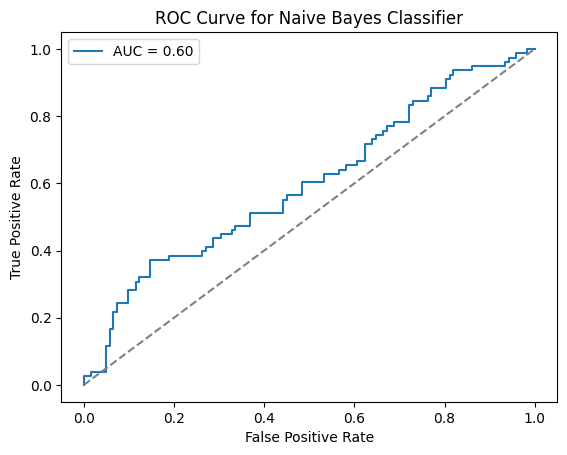

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities
y_probs = nb_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.legend()
plt.show()


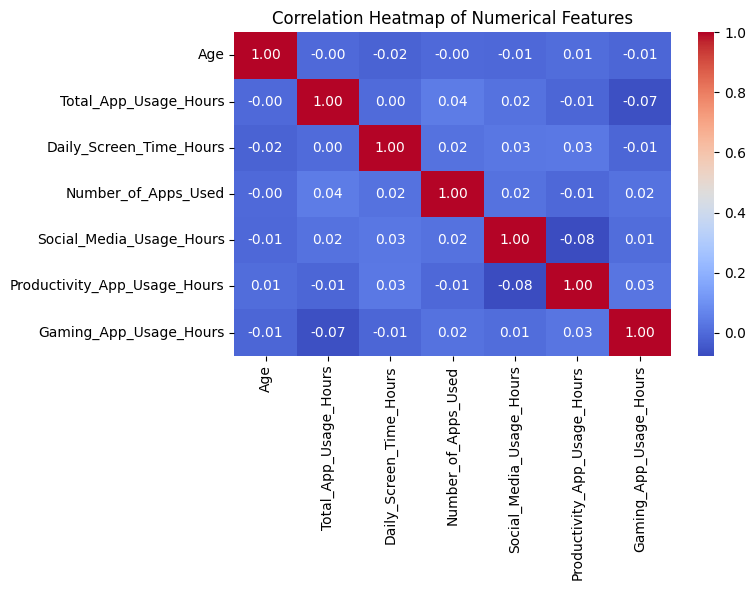

In [9]:
import seaborn as sns

# Load the dataset
df = pd.read_csv("mobile_usage_behavioral_analysis.csv")

# Optional: drop User_ID since it's just an identifier
numeric_features = df.select_dtypes(include='number').drop(columns=["User_ID"])

# Generate the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


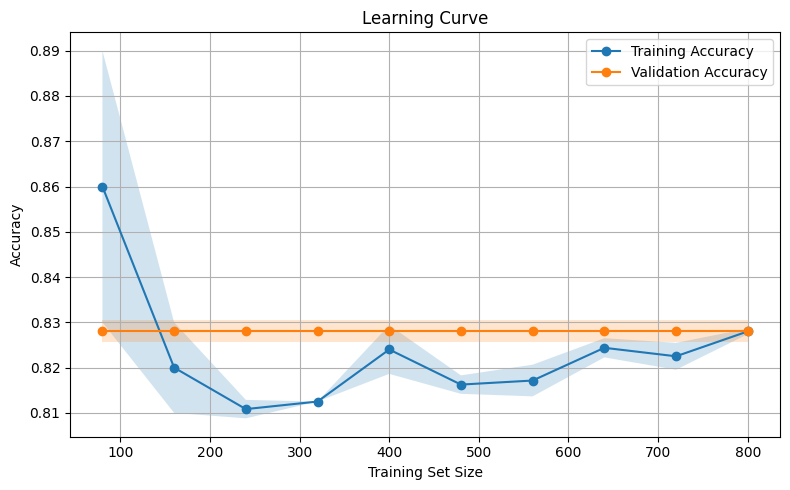

In [12]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    GaussianNB(), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()